BINARY RF TRUNCATED SVD + HEALTHCARE PATIENT CLUSTERING ANALYSIS

STEP 1: BINARY RF ONLY TRUNCATED SVD
Loaded aggregated data: (179, 465)
Found 460 RF columns
RF matrix shape: (179, 460)
Binary data sparsity: 92.2% (perfect for TruncatedSVD)
Active RF conditions: 460 out of 460

Top 10 most common RF conditions:
  Pain                          : 178 patients (99.4%)
  Dry Skin                      : 149 patients (83.2%)
  Wound                         : 146 patients (81.6%)
  Agitation                     : 143 patients (79.9%)
  Fall                          : 134 patients (74.9%)
  Weight Loss                   : 111 patients (62.0%)
  Incontinence                  : 108 patients (60.3%)
  Discomfort                    : 107 patients (59.8%)
  Confusion                     : 107 patients (59.8%)
  Reduced Mobility              :  96 patients (53.6%)

Applying TruncatedSVD...
SVD transformation complete:
  Components extracted: 80
  Variance explained: 0.872
  Components for 80% varia

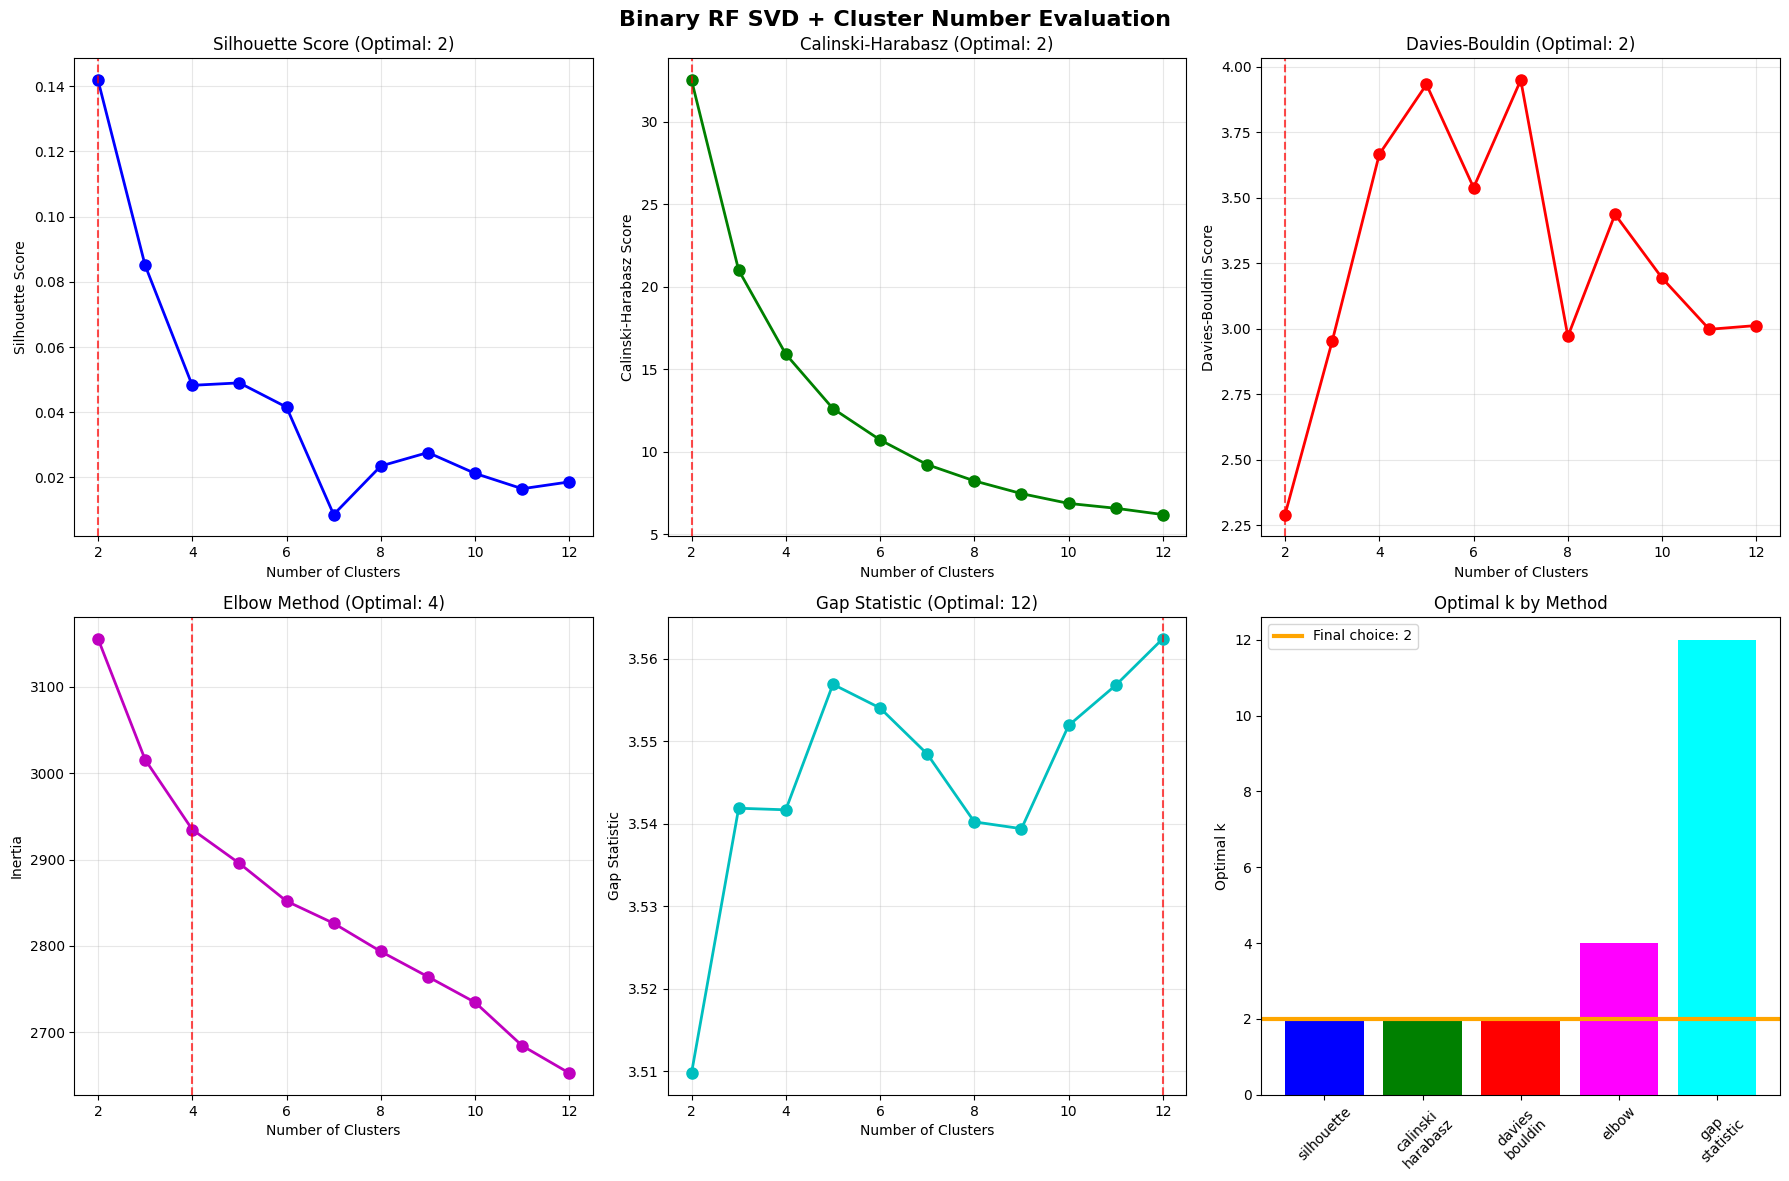


3. APPLYING MULTIPLE CLUSTERING ALGORITHMS
Applying K-Means clustering...
Applying Hierarchical clustering...
Applying Gaussian Mixture Model...
Applying DBSCAN...
DBSCAN found 1 clusters with 96 noise points

4. CLUSTERING ALGORITHM COMPARISON
K-Means        : Sil=0.142, Cal-Har=32.5, DB=2.291, Clusters=2
Hierarchical   : Sil=0.142, Cal-Har=32.5, DB=2.291, Clusters=2
Gaussian Mixture: Sil=0.142, Cal-Har=32.5, DB=2.291, Clusters=2
DBSCAN         : Skipped (single cluster)

🏆 BEST ALGORITHM: K-Means

5. CLUSTER VISUALIZATION
Computing t-SNE visualization...


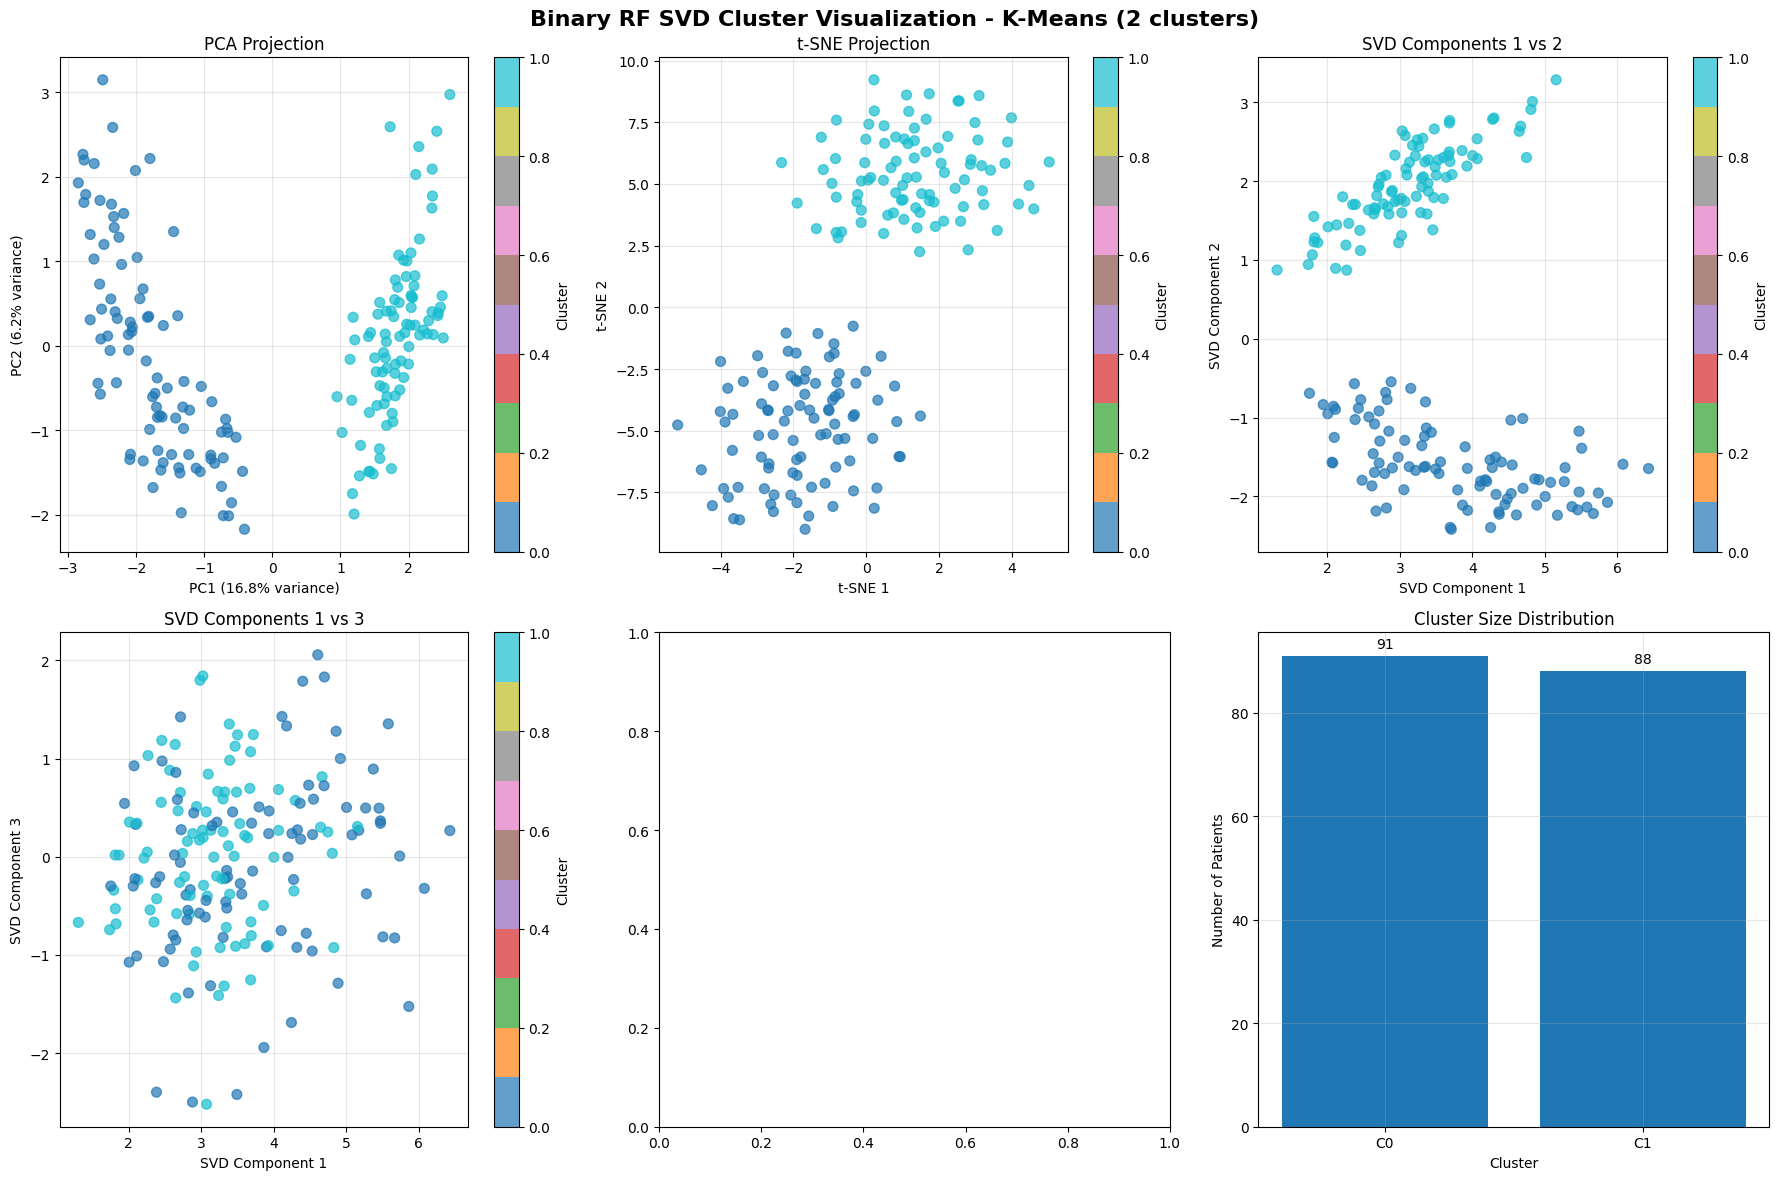

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

print("BINARY RF TRUNCATED SVD + HEALTHCARE PATIENT CLUSTERING ANALYSIS")
print("=" * 70)

# =====================================================
# STEP 1: BINARY RF ONLY TRUNCATED SVD ANALYSIS
# =====================================================

print(f"\nSTEP 1: BINARY RF ONLY TRUNCATED SVD")
print("=" * 50)

# Read the aggregated data
df = pd.read_csv('UpdatedDataFile_aggregated.csv')
print(f"Loaded aggregated data: {df.shape}")

# drop PersonID column
df = df.drop(columns=['PersonID'])

# Select only binary RF columns
rf_columns = [col for col in df.columns if col.startswith('RF_')]
print(f"Found {len(rf_columns)} RF columns")

# Get the binary RF data matrix
rf_matrix = df[rf_columns].fillna(0).values
print(f"RF matrix shape: {rf_matrix.shape}")

# Analyze sparsity
total_elements = rf_matrix.shape[0] * rf_matrix.shape[1]
zero_elements = (rf_matrix == 0).sum()
sparsity = zero_elements / total_elements
print(f"Binary data sparsity: {sparsity:.1%} (perfect for TruncatedSVD)")

# Check active conditions
rf_sums = df[rf_columns].sum()
active_conditions = rf_sums[rf_sums > 0].sort_values(ascending=False)
print(f"Active RF conditions: {len(active_conditions)} out of {len(rf_columns)}")

print(f"\nTop 10 most common RF conditions:")
for condition, count in active_conditions.head(10).items():
    prevalence = count / len(df) * 100
    clean_name = condition.replace('RF_', '').replace('_', ' ').title()
    print(f"  {clean_name[:30]:30}: {count:3d} patients ({prevalence:4.1f}%)")

# Apply TruncatedSVD to binary RF data
print(f"\nApplying TruncatedSVD...")
n_components = min(80, len(active_conditions), len(df)-1)
svd_model = TruncatedSVD(n_components=n_components, random_state=42)
rf_transformed = svd_model.fit_transform(rf_matrix)

print(f"SVD transformation complete:")
print(f"  Components extracted: {n_components}")
print(f"  Variance explained: {svd_model.explained_variance_ratio_.sum():.3f}")

# Find optimal number of components
cumulative_variance = np.cumsum(svd_model.explained_variance_ratio_)
n_80_percent = np.argmax(cumulative_variance >= 0.80) + 1
n_90_percent = np.argmax(cumulative_variance >= 0.90) + 1

print(f"  Components for 80% variance: {n_80_percent}")
print(f"  Components for 90% variance: {n_90_percent}")

# Component analysis
print(f"\nTop 10 SVD components:")
for i in range(min(10, n_components)):
    var_explained = svd_model.explained_variance_ratio_[i]
    cumulative = cumulative_variance[i]
    print(f"  SVD Component {i+1:2d}: {var_explained:.4f} ({var_explained*100:5.2f}%) | Cum: {cumulative:.3f}")

# Interpret components
print(f"\nComponent Interpretation (Top features for first 3 components):")
components_matrix = svd_model.components_

for comp_idx in range(min(3, components_matrix.shape[0])):
    print(f"\nSVD Component {comp_idx + 1}:")
    
    # Get loadings for this component
    loadings = components_matrix[comp_idx]
    top_indices = np.argsort(np.abs(loadings))[-10:][::-1]
    
    print(f"  Top contributing RF conditions:")
    for idx in top_indices:
        rf_name = rf_columns[idx].replace('RF_', '').replace('_', ' ').title()
        loading_val = loadings[idx]
        direction = "+" if loading_val > 0 else "-"
        print(f"    {direction}{abs(loading_val):.3f}: {rf_name}")

# Prepare SVD results for clustering
svd_df = pd.DataFrame(
    rf_transformed,
    columns=[f'SVD_Component_{i+1}' for i in range(n_components)],
    index=df.index
)

# Add metadata
svd_df['Gender'] = df['Gender']
svd_df['Age'] = df['Age']
svd_df['MUSTScore'] = df['MUSTScore']
svd_df['MaxWeightLossPercent'] = df['MaxWeightLossPercent']

print(f"\nSVD results dataframe created: {svd_df.shape}")

# Save SVD results in expected format
svd_df.to_csv('UpdatedDataFile_svd_transformed.csv', index=False)
df.to_csv('UpdatedDataFile_aggregated_full.csv', index=False)
print(f"✅ Saved: UpdatedDataFile_svd_transformed.csv")
print(f"✅ Saved: UpdatedDataFile_aggregated_full.csv")

# =====================================================
# STEP 2: HEALTHCARE PATIENT CLUSTERING ANALYSIS
# =====================================================

print(f"\n" + "="*70)
print("STEP 2: HEALTHCARE PATIENT CLUSTERING ANALYSIS")
print("=" * 70)

# Load SVD-transformed data
df_svd = svd_df.copy()  # We just created it above
df_original = df.copy()  # Original data

print(f"✅ Using SVD-transformed data: {df_svd.shape}")
print(f"✅ Using original data for interpretation: {df_original.shape}")

print(f"Dataset overview:")
print(f"  Patients: {len(df_svd)}")
print(f"  SVD Components: {len([col for col in df_svd.columns if col.startswith('SVD_Component')])}")

# Prepare data for clustering
svd_cols = [col for col in df_svd.columns if col.startswith('SVD_Component')]
X = df_svd[svd_cols].values

print(f"Clustering data shape: {X.shape}")

# =====================================================
# 1. OPTIMAL CLUSTER NUMBER DETERMINATION
# =====================================================

print(f"\n1. DETERMINING OPTIMAL NUMBER OF CLUSTERS")
print("=" * 50)

def evaluate_clusters(X, max_clusters=15):
    """Evaluate different numbers of clusters using multiple metrics"""
    
    cluster_range = range(2, min(max_clusters + 1, len(X) // 2))
    
    # Metrics storage
    metrics = {
        'silhouette': [],
        'calinski_harabasz': [],
        'davies_bouldin': [],
        'inertia': [],
        'gap_statistic': []
    }
    
    print(f"Testing cluster range: {min(cluster_range)} to {max(cluster_range)}")
    
    for k in cluster_range:
        # K-means clustering
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        
        # Calculate metrics
        sil_score = silhouette_score(X, labels)
        cal_score = calinski_harabasz_score(X, labels)
        db_score = davies_bouldin_score(X, labels)
        inertia = kmeans.inertia_
        
        metrics['silhouette'].append(sil_score)
        metrics['calinski_harabasz'].append(cal_score)
        metrics['davies_bouldin'].append(db_score)
        metrics['inertia'].append(inertia)
        
        # Gap statistic (simplified)
        random_data = np.random.uniform(X.min(), X.max(), X.shape)
        kmeans_random = KMeans(n_clusters=k, random_state=42, n_init=10)
        random_inertia = kmeans_random.fit(random_data).inertia_
        gap = np.log(random_inertia) - np.log(inertia)
        metrics['gap_statistic'].append(gap)
        
        print(f"  k={k:2d}: Silhouette={sil_score:.3f}, Calinski-Harabasz={cal_score:.1f}, Davies-Bouldin={db_score:.3f}")
    
    return cluster_range, metrics

# Evaluate clusters
cluster_range, metrics = evaluate_clusters(X, max_clusters=12)

# Find optimal k for each method
optimal_k = {}
optimal_k['silhouette'] = cluster_range[np.argmax(metrics['silhouette'])]
optimal_k['calinski_harabasz'] = cluster_range[np.argmax(metrics['calinski_harabasz'])]
optimal_k['davies_bouldin'] = cluster_range[np.argmin(metrics['davies_bouldin'])]

# Elbow method for inertia
def find_elbow(values):
    """Find elbow point using the rate of change"""
    if len(values) < 3:
        return 0
    diffs = np.diff(values)
    diffs2 = np.diff(diffs)
    if len(diffs2) > 0:
        return np.argmax(diffs2) + 2
    return 0

elbow_idx = find_elbow(metrics['inertia'])
if elbow_idx > 0 and elbow_idx < len(cluster_range):
    optimal_k['elbow'] = cluster_range[elbow_idx]
else:
    optimal_k['elbow'] = cluster_range[len(cluster_range)//2]

optimal_k['gap_statistic'] = cluster_range[np.argmax(metrics['gap_statistic'])]

print(f"\nOptimal cluster numbers by different methods:")
for method, k in optimal_k.items():
    print(f"  {method:20}: {k} clusters")

# Choose final k (majority vote or best silhouette)
k_counts = list(optimal_k.values())
final_k = max(set(k_counts), key=k_counts.count) if len(set(k_counts)) < len(k_counts) else optimal_k['silhouette']

print(f"\n🎯 RECOMMENDED NUMBER OF CLUSTERS: {final_k}")



# =====================================================
# 2. VISUALIZATION OF CLUSTER EVALUATION
# =====================================================

print(f"\n2. CLUSTER EVALUATION VISUALIZATION")
print("=" * 50)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Binary RF SVD + Cluster Number Evaluation', fontsize=16, fontweight='bold')

# Silhouette Score
axes[0, 0].plot(cluster_range, metrics['silhouette'], 'bo-', linewidth=2, markersize=8)
axes[0, 0].axvline(x=optimal_k['silhouette'], color='red', linestyle='--', alpha=0.7)
axes[0, 0].set_xlabel('Number of Clusters')
axes[0, 0].set_ylabel('Silhouette Score')
axes[0, 0].set_title(f'Silhouette Score (Optimal: {optimal_k["silhouette"]})')
axes[0, 0].grid(True, alpha=0.3)

# Calinski-Harabasz Score
axes[0, 1].plot(cluster_range, metrics['calinski_harabasz'], 'go-', linewidth=2, markersize=8)
axes[0, 1].axvline(x=optimal_k['calinski_harabasz'], color='red', linestyle='--', alpha=0.7)
axes[0, 1].set_xlabel('Number of Clusters')
axes[0, 1].set_ylabel('Calinski-Harabasz Score')
axes[0, 1].set_title(f'Calinski-Harabasz (Optimal: {optimal_k["calinski_harabasz"]})')
axes[0, 1].grid(True, alpha=0.3)

# Davies-Bouldin Score
axes[0, 2].plot(cluster_range, metrics['davies_bouldin'], 'ro-', linewidth=2, markersize=8)
axes[0, 2].axvline(x=optimal_k['davies_bouldin'], color='red', linestyle='--', alpha=0.7)
axes[0, 2].set_xlabel('Number of Clusters')
axes[0, 2].set_ylabel('Davies-Bouldin Score')
axes[0, 2].set_title(f'Davies-Bouldin (Optimal: {optimal_k["davies_bouldin"]})')
axes[0, 2].grid(True, alpha=0.3)

# Elbow Plot
axes[1, 0].plot(cluster_range, metrics['inertia'], 'mo-', linewidth=2, markersize=8)
axes[1, 0].axvline(x=optimal_k['elbow'], color='red', linestyle='--', alpha=0.7)
axes[1, 0].set_xlabel('Number of Clusters')
axes[1, 0].set_ylabel('Inertia')
axes[1, 0].set_title(f'Elbow Method (Optimal: {optimal_k["elbow"]})')
axes[1, 0].grid(True, alpha=0.3)

# Gap Statistic
axes[1, 1].plot(cluster_range, metrics['gap_statistic'], 'co-', linewidth=2, markersize=8)
axes[1, 1].axvline(x=optimal_k['gap_statistic'], color='red', linestyle='--', alpha=0.7)
axes[1, 1].set_xlabel('Number of Clusters')
axes[1, 1].set_ylabel('Gap Statistic')
axes[1, 1].set_title(f'Gap Statistic (Optimal: {optimal_k["gap_statistic"]})')
axes[1, 1].grid(True, alpha=0.3)

# Summary barplot
methods = list(optimal_k.keys())
k_values = list(optimal_k.values())
axes[1, 2].bar(range(len(methods)), k_values, color=['blue', 'green', 'red', 'magenta', 'cyan'])
axes[1, 2].set_xticks(range(len(methods)))
axes[1, 2].set_xticklabels([m.replace('_', '\n') for m in methods], rotation=45)
axes[1, 2].set_ylabel('Optimal k')
axes[1, 2].set_title('Optimal k by Method')
axes[1, 2].axhline(y=final_k, color='orange', linestyle='-', linewidth=3, label=f'Final choice: {final_k}')
axes[1, 2].legend()

plt.tight_layout()
plt.show()


# =====================================================
# 3. APPLY MULTIPLE CLUSTERING ALGORITHMS
# =====================================================

print(f"\n3. APPLYING MULTIPLE CLUSTERING ALGORITHMS")
print("=" * 50)

clustering_results = {}

# K-Means
print("Applying K-Means clustering...")
kmeans = KMeans(n_clusters=final_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X)
clustering_results['K-Means'] = {
    'labels': kmeans_labels,
    'model': kmeans,
    'centers': kmeans.cluster_centers_
}

# Hierarchical Clustering
print("Applying Hierarchical clustering...")
hierarchical = AgglomerativeClustering(n_clusters=final_k)
hierarchical_labels = hierarchical.fit_predict(X)
clustering_results['Hierarchical'] = {
    'labels': hierarchical_labels,
    'model': hierarchical
}

# Gaussian Mixture Model
print("Applying Gaussian Mixture Model...")
gmm = GaussianMixture(n_components=final_k, random_state=42)
gmm_labels = gmm.fit_predict(X)
clustering_results['Gaussian Mixture'] = {
    'labels': gmm_labels,
    'model': gmm,
    'probabilities': gmm.predict_proba(X)
}

# DBSCAN (parameter tuning)
print("Applying DBSCAN...")
nn = NearestNeighbors(n_neighbors=4)
nn.fit(X)
distances, indices = nn.kneighbors(X)
distances = np.sort(distances[:, 3], axis=0)
eps_optimal = distances[len(distances)//3]

dbscan = DBSCAN(eps=eps_optimal, min_samples=3)
dbscan_labels = dbscan.fit_predict(X)

n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

clustering_results['DBSCAN'] = {
    'labels': dbscan_labels,
    'model': dbscan,
    'n_clusters': n_clusters_dbscan,
    'n_noise': n_noise,
    'eps': eps_optimal
}

print(f"DBSCAN found {n_clusters_dbscan} clusters with {n_noise} noise points")



# =====================================================
# 4. EVALUATE AND COMPARE CLUSTERING ALGORITHMS
# =====================================================

print(f"\n4. CLUSTERING ALGORITHM COMPARISON")
print("=" * 50)

algorithm_scores = {}

for name, result in clustering_results.items():
    labels = result['labels']
    
    if name == 'DBSCAN' and len(set(labels)) <= 1:
        print(f"{name:15}: Skipped (insufficient clusters)")
        continue
    
    # Handle noise points for DBSCAN
    if -1 in labels:
        valid_idx = labels != -1
        if np.sum(valid_idx) < 10:
            print(f"{name:15}: Skipped (too many noise points)")
            continue
        X_clean = X[valid_idx]
        labels_clean = labels[valid_idx]
    else:
        X_clean = X
        labels_clean = labels
    
    if len(set(labels_clean)) <= 1:
        print(f"{name:15}: Skipped (single cluster)")
        continue
    
    # Calculate metrics
    sil_score = silhouette_score(X_clean, labels_clean)
    cal_score = calinski_harabasz_score(X_clean, labels_clean)
    db_score = davies_bouldin_score(X_clean, labels_clean)
    
    algorithm_scores[name] = {
        'silhouette': sil_score,
        'calinski_harabasz': cal_score,
        'davies_bouldin': db_score,
        'n_clusters': len(set(labels_clean))
    }
    
    print(f"{name:15}: Sil={sil_score:.3f}, Cal-Har={cal_score:.1f}, DB={db_score:.3f}, Clusters={len(set(labels_clean))}")

# Choose best algorithm
if algorithm_scores:
    best_algorithm = max(algorithm_scores.items(), key=lambda x: x[1]['silhouette'])[0]
    print(f"\n🏆 BEST ALGORITHM: {best_algorithm}")
    final_labels = clustering_results[best_algorithm]['labels']
else:
    best_algorithm = 'K-Means'
    final_labels = kmeans_labels
    print(f"\n🏆 DEFAULT ALGORITHM: {best_algorithm}")


# =====================================================
# 5. CLUSTER VISUALIZATION
# =====================================================

print(f"\n5. CLUSTER VISUALIZATION")
print("=" * 50)

# PCA for 2D visualization
pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X)

# t-SNE for 2D visualization (if dataset not too large)
if len(X) <= 1000:
    print("Computing t-SNE visualization...")
    tsne_2d = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X)//4))
    X_tsne_2d = tsne_2d.fit_transform(X)
else:
    print("Dataset too large for t-SNE, skipping...")
    X_tsne_2d = None

# Create visualization
if X_tsne_2d is not None:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
else:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

fig.suptitle(f'Binary RF SVD Cluster Visualization - {best_algorithm} ({final_k} clusters)', fontsize=16, fontweight='bold')

# PCA plot
ax1 = axes[0, 0]
scatter = ax1.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=final_labels, cmap='tab10', alpha=0.7, s=50)
ax1.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%} variance)')
ax1.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%} variance)')
ax1.set_title('PCA Projection')
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax1, label='Cluster')

# t-SNE plot
if X_tsne_2d is not None:
    ax2 = axes[0, 1]
    scatter2 = ax2.scatter(X_tsne_2d[:, 0], X_tsne_2d[:, 1], c=final_labels, cmap='tab10', alpha=0.7, s=50)
    ax2.set_xlabel('t-SNE 1')
    ax2.set_ylabel('t-SNE 2')
    ax2.set_title('t-SNE Projection')
    ax2.grid(True, alpha=0.3)
    plt.colorbar(scatter2, ax=ax2, label='Cluster')

# Top 3 SVD components plots
svd_plot_positions = [(0, 2), (1, 0), (1, 1)] if X_tsne_2d is not None else [(0, 1), (1, 0)]

for i, pos in enumerate(svd_plot_positions[:2]):
    if i + 1 < X.shape[1]:
        ax = axes[pos[0], pos[1]]
        scatter = ax.scatter(X[:, 0], X[:, i + 1], c=final_labels, cmap='tab10', alpha=0.7, s=50)
        ax.set_xlabel('SVD Component 1')
        ax.set_ylabel(f'SVD Component {i + 2}')
        ax.set_title(f'SVD Components 1 vs {i + 2}')
        ax.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax, label='Cluster')

# Cluster size distribution
ax_size = axes[1, 2] if X_tsne_2d is not None else axes[1, 1]
unique_labels, counts = np.unique(final_labels, return_counts=True)
if -1 in unique_labels:
    noise_idx = unique_labels == -1
    cluster_labels = unique_labels[~noise_idx]
    cluster_counts = counts[~noise_idx]
    noise_count = counts[noise_idx][0] if np.any(noise_idx) else 0
    
    bars = ax_size.bar(range(len(cluster_labels)), cluster_counts)
    if noise_count > 0:
        ax_size.bar([len(cluster_labels)], [noise_count], color='red', alpha=0.7, label=f'Noise ({noise_count})')
    ax_size.set_xticks(range(len(cluster_labels)))
    ax_size.set_xticklabels([f'C{i}' for i in cluster_labels])
else:
    bars = ax_size.bar(range(len(unique_labels)), counts)
    ax_size.set_xticks(range(len(unique_labels)))
    ax_size.set_xticklabels([f'C{i}' for i in unique_labels])

ax_size.set_xlabel('Cluster')
ax_size.set_ylabel('Number of Patients')
ax_size.set_title('Cluster Size Distribution')
ax_size.grid(True, alpha=0.3)

# Add count labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax_size.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [12]:
# =====================================================
# 6. CLUSTER CHARACTERIZATION WITH RF CONDITIONS
# =====================================================

print(f"\n6. BINARY RF CLUSTER CHARACTERIZATION")
print("=" * 50)

def characterize_rf_clusters(final_labels, df_original, rf_columns, svd_cols, X):
    """Characterize clusters based on original RF conditions and SVD components"""
    
    # Remove noise points if present
    if -1 in final_labels:
        valid_idx = final_labels != -1
        labels_clean = final_labels[valid_idx]
        df_clean = df_original.iloc[valid_idx]
        X_clean = X[valid_idx]
    else:
        labels_clean = final_labels
        df_clean = df_original
        X_clean = X
    
    unique_clusters = np.unique(labels_clean)
    cluster_interpretations = {}
    
    print("RF-based cluster profiles:")
    print("-" * 70)
    
    for cluster_id in unique_clusters:
        cluster_mask = labels_clean == cluster_id
        cluster_patients = df_clean.iloc[cluster_mask]
        cluster_svd = X_clean[cluster_mask]
        
        cluster_size = np.sum(cluster_mask)
        cluster_percentage = cluster_size / len(labels_clean) * 100
        
        print(f"\n🏥 CLUSTER {cluster_id} (n={cluster_size}, {cluster_percentage:.1f}%)")
        
        # Demographics
        avg_age = cluster_patients['Age'].mean()
        gender_dist = cluster_patients['Gender'].value_counts(normalize=True)
        must_dist = cluster_patients['MUSTScore'].mean()
        weight_loss = cluster_patients['MaxWeightLossPercent'].mean()
        
        print(f"  Demographics:")
        print(f"    Average Age: {avg_age:.1f} years")
        print(f"    Gender: {dict(gender_dist)}")
        print(f"    Average MUST Score: {must_dist:.2f}")
        print(f"    Average Weight Loss: {weight_loss:.1f}%")
        
        # Top SVD components
        svd_means = np.mean(cluster_svd, axis=0)
        top_svd_components = np.argsort(np.abs(svd_means))[-3:][::-1]
        
        print(f"  Top SVD Components:")
        for i, comp_idx in enumerate(top_svd_components):
            comp_value = svd_means[comp_idx]
            direction = "High" if comp_value > 0.1 else "Low" if comp_value < -0.1 else "Moderate"
            print(f"    SVD Component {comp_idx+1}: {direction:8} ({comp_value:6.3f})")
        
        # Most prevalent RF conditions in this cluster
        rf_prevalence = cluster_patients[rf_columns].mean().sort_values(ascending=False)
        top_rf_conditions = rf_prevalence[rf_prevalence > 0.1]  # At least 10% prevalence
        
        print(f"  Top RF Conditions (>10% prevalence):")
        if len(top_rf_conditions) > 0:
            for rf, prevalence in top_rf_conditions.head(20).items():
                clean_name = rf.replace('RF_', '').replace('_', ' ').title()
                print(f"    {clean_name[:35]:35}: {prevalence:.1%}")
        else:
            print(f"    No high-prevalence conditions (relatively healthy)")
        
        # Clinical phenotype determination
        phenotype = determine_rf_phenotype(top_rf_conditions, avg_age, must_dist, weight_loss)
        print(f"  🎯 Clinical Phenotype: {phenotype}")
        
        cluster_interpretations[cluster_id] = {
            'size': cluster_size,
            'percentage': cluster_percentage,
            'avg_age': avg_age,
            'gender_dist': dict(gender_dist),
            'must_score': must_dist,
            'weight_loss': weight_loss,
            'top_rf_conditions': dict(top_rf_conditions.head(5)),
            'phenotype': phenotype
        }
    
    return cluster_interpretations

def determine_rf_phenotype(top_conditions, avg_age, must_score, weight_loss):
    """Determine clinical phenotype based on RF conditions and demographics"""
    
    if len(top_conditions) == 0:
        return "Relatively Healthy / Low Medical Complexity"
    
    condition_names = [name.lower() for name in top_conditions.index]
    condition_names_str = ' '.join(condition_names)
    
    # Cardiovascular conditions
    cardio_keywords = ['heart', 'cardiac', 'blood', 'pressure', 'circulation', 'angina']
    cardio_score = sum(1 for keyword in cardio_keywords if keyword in condition_names_str)
    
    # Neurological/cognitive conditions  
    neuro_keywords = ['dementia', 'cognitive', 'confusion', 'delirium', 'parkinson', 'stroke']
    neuro_score = sum(1 for keyword in neuro_keywords if keyword in condition_names_str)
    
    # Mobility/frailty conditions
    mobility_keywords = ['mobility', 'fall', 'fracture', 'weakness', 'frailty', 'dependency']
    mobility_score = sum(1 for keyword in mobility_keywords if keyword in condition_names_str)
    
    # Gastrointestinal conditions
    gi_keywords = ['bowel', 'gastro', 'constipation', 'diarrhea', 'nutrition', 'appetite']
    gi_score = sum(1 for keyword in gi_keywords if keyword in condition_names_str)
    
    # Pain/comfort conditions
    pain_keywords = ['pain', 'analgesic', 'morphine', 'wound', 'ulcer', 'discomfort']
    pain_score = sum(1 for keyword in pain_keywords if keyword in condition_names_str)
    
    # Medication complexity
    med_keywords = ['medication', 'polypharmacy', 'antidepressant', 'antipsychotic']
    med_score = sum(1 for keyword in med_keywords if keyword in condition_names_str)
    
    # Determine phenotype based on dominant condition categories
    scores = {
        'cardiovascular': cardio_score,
        'neurological': neuro_score, 
        'mobility': mobility_score,
        'gastrointestinal': gi_score,
        'pain': pain_score,
        'medication': med_score
    }
    
    max_category = max(scores.items(), key=lambda x: x[1])
    
    if must_score >= 2 and weight_loss > 10:
        return f"High Malnutrition Risk + {max_category[0].title()} Focus"
    elif avg_age >= 90:
        return f"Advanced Elderly + {max_category[0].title()} Conditions"
    elif max_category[1] >= 2:
        return f"{max_category[0].title()}-Dominant Patient Profile"
    else:
        return "Mixed Medical Complexity"

# Apply RF cluster characterization
cluster_interpretations = characterize_rf_clusters(final_labels, df_original, rf_columns, svd_cols, X)


6. BINARY RF CLUSTER CHARACTERIZATION
RF-based cluster profiles:
----------------------------------------------------------------------

🏥 CLUSTER 0 (n=91, 50.8%)
  Demographics:
    Average Age: 86.7 years
    Gender: {0: np.float64(0.5604395604395604), 1: np.float64(0.43956043956043955)}
    Average MUST Score: 1.53
    Average Weight Loss: 9.7%
  Top SVD Components:
    SVD Component 1: High     ( 3.761)
    SVD Component 2: Low      (-1.580)
    SVD Component 3: Moderate (-0.096)
  Top RF Conditions (>10% prevalence):
    Mobility And Care Dependency       : 100.0%
    Pain                               : 98.9%
    Reduced Mobility                   : 98.9%
    Dry Skin                           : 84.6%
    Nail Abnormality                   : 82.4%
    Refusal Of Care                    : 78.0%
    Agitation                          : 78.0%
    Suboptimal Intake                  : 76.9%
    Eating Dependency                  : 75.8%
    Urinary Incontinence               : 74.7%


In [13]:
# =====================================================
# 7. SAVE COMPREHENSIVE RESULTS
# =====================================================

print(f"\n7. SAVING COMPREHENSIVE RESULTS")
print("=" * 50)

# Create comprehensive results dataframe
results_df = df_svd.copy()
results_df['Cluster'] = final_labels
results_df['Cluster_Algorithm'] = best_algorithm

# Add cluster probabilities if available (for GMM)
if best_algorithm == 'Gaussian Mixture' and 'probabilities' in clustering_results[best_algorithm]:
    probs = clustering_results[best_algorithm]['probabilities']
    for i in range(probs.shape[1]):
        results_df[f'Cluster_{i}_Probability'] = probs[:, i]

# Save main results
results_filename = 'Binary_RF_SVD_clustering_results.csv'
results_df.to_csv(results_filename, index=False)
print(f"✅ Main clustering results: {results_filename}")

print(f"\n" + "="*70)
print(f"BINARY RF SVD + CLUSTERING ANALYSIS COMPLETE!")
print(f"="*70)
print(f"🧬 SVD Method: TruncatedSVD on {len(rf_columns)} binary RF conditions")
print(f"🎯 Clustering: {best_algorithm}")
print(f"📊 Clusters: {len(set(final_labels)) - (1 if -1 in final_labels else 0)}")
print(f"👥 Patients: {len(df_svd)}")
print(f"📈 Dimensionality Reduction: {len(rf_columns)} → {n_components} ({len(rf_columns)/n_components:.1f}:1)")
print(f"📁 Main Results: {results_filename}")

print(f"🎉 Analysis reveals {len(cluster_interpretations)} distinct patient phenotypes")
print(f"   based on {len(active_conditions)} active medical conditions!")


7. SAVING COMPREHENSIVE RESULTS
✅ Main clustering results: Binary_RF_SVD_clustering_results.csv

BINARY RF SVD + CLUSTERING ANALYSIS COMPLETE!
🧬 SVD Method: TruncatedSVD on 460 binary RF conditions
🎯 Clustering: K-Means
📊 Clusters: 2
👥 Patients: 179
📈 Dimensionality Reduction: 460 → 80 (5.8:1)
📁 Main Results: Binary_RF_SVD_clustering_results.csv
🎉 Analysis reveals 2 distinct patient phenotypes
   based on 460 active medical conditions!


In [14]:
# FIXED MODEL SAVING CODE - ADD THIS TO YOUR ORIGINAL SCRIPT
# =====================================================
# 8. SAVE TRAINED MODELS FOR FUTURE PREDICTIONS (FIXED)
# =====================================================

print(f"\n8. SAVING TRAINED MODELS (FIXED VERSION)")
print("=" * 50)

import pickle

# Create a model package with ONLY the essential components
model_package = {
    'svd_model': svd_model,
    'best_clustering_algorithm': best_algorithm,
    'best_clustering_model': clustering_results[best_algorithm]['model'],
    'rf_columns': rf_columns,
    'n_components': n_components,
    'final_k': final_k,
    'cluster_interpretations': cluster_interpretations,
    'algorithm_scores': algorithm_scores,
    'optimal_k_methods': optimal_k,
    'preprocessing_info': {
        'original_shape': df_original.shape,
        'rf_matrix_shape': rf_matrix.shape,
        'sparsity': sparsity,
        'active_conditions': len(active_conditions)
    }
}

# Add additional models if they exist and performed well
if 'K-Means' in clustering_results and best_algorithm != 'K-Means':
    model_package['kmeans_model'] = clustering_results['K-Means']['model']

if 'Gaussian Mixture' in clustering_results and best_algorithm != 'Gaussian Mixture':
    model_package['gmm_model'] = clustering_results['Gaussian Mixture']['model']

# REMOVED: prediction_pipeline creation and saving (this was causing the pickle issue)

# Save the complete model package
model_filename = 'patient_classifier_model.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(model_package, f)

print(f"✅ Complete model package saved: {model_filename}")
print(f"   - SVD transformer (TruncatedSVD)")
print(f"   - Best clustering model ({best_algorithm})")
print(f"   - RF columns list")
print(f"   - Cluster interpretations")
print(f"   - Model metadata")



8. SAVING TRAINED MODELS (FIXED VERSION)
✅ Complete model package saved: patient_classifier_model.pkl
   - SVD transformer (TruncatedSVD)
   - Best clustering model (K-Means)
   - RF columns list
   - Cluster interpretations
   - Model metadata
